In [141]:
import torch
from torch import nn, optim, autograd
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from dataclasses import dataclass
import time
import sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
torch.set_num_threads(1)
torch.manual_seed(1)


device = torch.device("cpu") #torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu") #

if device == torch.device("cuda:0"):
  print('Everything looks good; continue')
else:
  # It is OK if you cannot connect to a GPU. In this case, training the model for
  # 2 epoch is sufficient to get full mark. (NOTE THAT 2 epoch takes approximately 1.5 hours to train for CPU)
  print('GPU is not detected. Make sure you have chosen the right runtime type')

GPU is not detected. Make sure you have chosen the right runtime type


In [142]:
@dataclass
class GMM_hp:
    lambda_ : float          =  0.5
    mu      =  [1,-1]
    sigma       = [0.5,0.5]

        
hp = GMM_hp()

# Q1

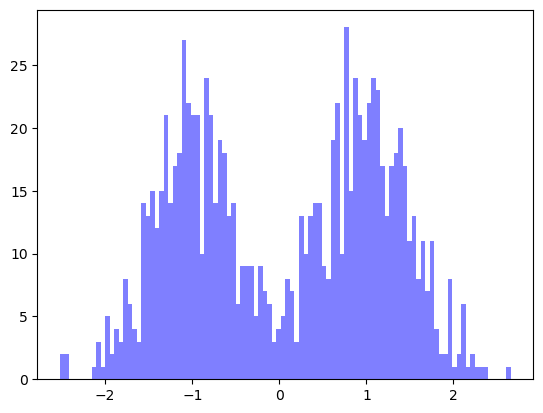

In [163]:

def GMMsample(gmm:GMM_hp, n=1000, b=50):
    U_ = torch.rand(size=(n,), device=device)
    mask = U_ < gmm.lambda_
    S1 = torch.randn(size=U_.shape,device=device)*gmm.sigma[0] + gmm.mu[0]
    S2 = torch.randn(size=U_.shape,device=device)*gmm.sigma[1] + gmm.mu[1]
    samples = torch.where(mask, S1, S2)
    # hist = torch.histc(samples, bins = b,min = 0, max = 1) #torchist.histogramdd(samples,bins=b,low=None , upp = None) #
    return samples

bins = 100
number_samples =1000
samples = GMMsample(hp,n=number_samples , b=bins)
n, bins, patches=plt.hist(samples,bins,facecolor='blue', alpha=0.5)
plt.savefig('Q1.png')
plt.show()

# Q2

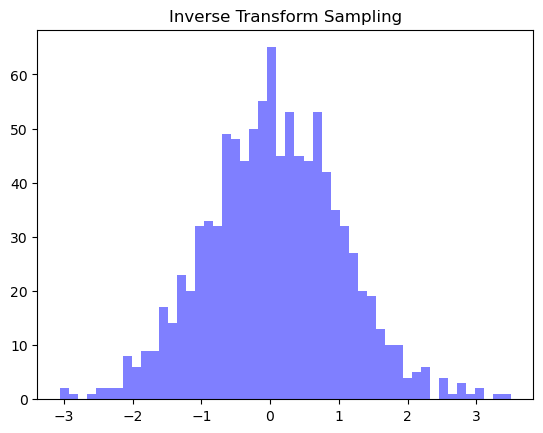

In [170]:
import matplotlib.pyplot as plt
import torchist
def GMMinv(X , gmm:GMM_hp, b=50):
    
    two_  = torch.tensor(2, dtype=torch.int8)
    # 1) cdf of GMM w_1*F1 + w_2*F2 ref : https://stackoverflow.com/questions/48647616/scikitlearn-how-can-i-get-cdf-of-a-gaussian-mixture-model
    
    # 1a CDF of F1 and F2 
    # ref1 : https://www.milefoot.com/math/stat/pdfc-normal.htm#:~:text=With%20this%20approach%2C%20the%20Gaussian,(x%E2%88%9A2)%5D.
    # ref2 : https://www.probabilitycourse.com/chapter4/4_2_3_normal.php#:~:text=.-,To%20find%20the%20CDF,-of
    F1 = 0.5 * (1 + torch.erf((X - gmm.mu[0]) / (gmm.sigma[0] * torch.sqrt(two_))))  # mixure parameters are given 
    F2 =  0.5 * (1 + torch.erf((X - gmm.mu[1]) / (gmm.sigma[1] * torch.sqrt(two_))))
    #cdf_GMM = ((gmm.lambda_)/gmm.sigma[0])*F1        +     ( (1-gmm.lambda_)/gmm.sigma[1])*F2
    cdf_GMM = ((gmm.lambda_))*F1        +     ( (1-gmm.lambda_) )*F2
    
    # 2) calculating inverse cdf of standard normal distribution
    #p = torch.clamp(cdf_GMM, 1e-9, 1 - 1e-9)    # for numerical satbility 
    z = torch.sqrt(two_) * torch.erfinv(2 * cdf_GMM - 1) # ref:https://stats.stackexchange.com/questions/187828/how-are-the-error-function-and-standard-normal-distribution-function-related
    return z

bins = 50
number_samples =1000
samples = GMMsample(hp,n=number_samples , b=bins)
inverse_dist = GMMinv(samples, hp, b=bins)
n, bins, patches=plt.hist(inverse_dist,bins,facecolor='blue', alpha=0.5)
plt.title('Inverse Transform Sampling')
plt.savefig('Q2.png')
# plt.show()

# Q3

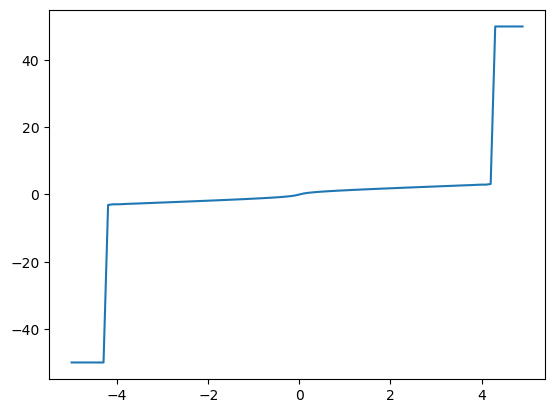

In [172]:
import matplotlib.pyplot as plt
import torchist
import pdb

def cdf_normal_distribution(p):
    two_  = torch.tensor(2, dtype=torch.int8)
    F1 = 0.5 * (1 + torch.erf(( p  ) / torch.sqrt(two_)))  # mixure parameters are given 
    return F1

def cdf_gmm(p , gmm:GMM_hp = hp ):
    two_  = torch.tensor(2, dtype=torch.int8)
    F1 = 0.5 * (1 + torch.erf(( p  - gmm.mu[0]) / (gmm.sigma[0] *torch.sqrt(two_))))  # mixure parameters are given 
    F2 =  0.5 * (1 + torch.erf(( p  - gmm.mu[1]) / (gmm.sigma[1] *torch.sqrt(two_))))
    #cdf_GMM = ((gmm.lambda_)/gmm.sigma[0])*F1        +     ( (1-gmm.lambda_)/gmm.sigma[1])*F2
    cdf_GMM = ((gmm.lambda_))*F1        +     ( (1-gmm.lambda_) )*F2
    return cdf_GMM
def BinarySearch(F, u, lb=torch.tensor(-100, dtype=torch.float32), ub=torch.tensor(100, dtype=torch.float32), maxiter=torch.tensor(100, dtype=torch.int8), tol=torch.tensor(1e-5, dtype=torch.float32)):
    lb_ = lb
    ub_ = ub
    def set_lower_bound(F,u,lb_,ub_):
        #pdb.set_trace()
        while F(lb_)> u :
            #print(lb_ , F(lb_), u)
            ub_ = lb_
            lb_ =2*lb_
        #print("in lower bound", lb_,ub_)
        return lb_,ub_
    
    def set_upper_bound(F,u,lb_,ub_):
        while F(ub_)<u:
            lb_ = ub_ 
            ub_ = 2*ub_
        #print("in upper bound", lb_,ub_)
        return lb_,ub_
   
    lb_,ub_ = set_lower_bound(F,u,lb_,ub_)
    lb_,ub_ = set_upper_bound(F,u,lb_,ub_)
    #print(lb_,ub_)
    for i in range(maxiter.item()):
        #print(i)
        x = (lb_ +  ub_)/2
        t = F(x)
        if t> u:
            ub_ = x
        else:
            lb_ = x
        if torch.abs(t-u)<tol :
            break
    return x
Zs=  torch.arange(-5,5,0.1)
x = torch.zeros_like(Zs)
gmm = hp
U = torch.zeros_like(Zs)
for i in range(len(Zs)):
    u  = cdf_normal_distribution(Zs[i])
    U[i] = u
    x[i] = BinarySearch(cdf_gmm, u, lb=torch.tensor(-100, dtype=torch.float32), ub=torch.tensor(100, dtype=torch.float32), maxiter=torch.tensor(100, dtype=torch.int8), tol=torch.tensor(1e-5, dtype=torch.float32))
    
plt.plot(Zs,x)
plt.savefig('Q3.png')

# Q4

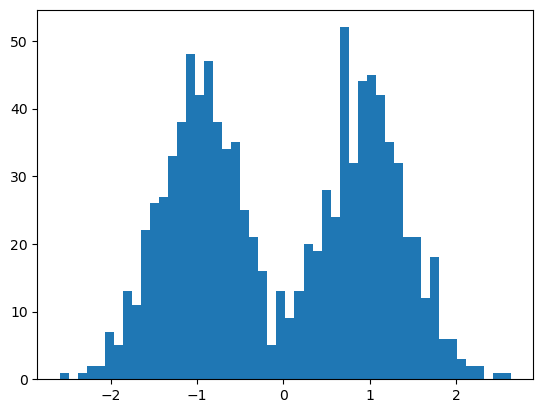

In [173]:
def PushForward(F,z,b=1000):
    X = torch.zeros_like(z)
    u = 0.5*(1+torch.erf(z/np.sqrt(2)))
    for i in range(len(z)):
      X[i] = BinarySearch(F,u[i])
    return X
n = 1000
z = torch.randn(n)
bins =50
X = PushForward(cdf_gmm,z,b=bins)
plt.hist(X,bins=bins)
plt.savefig('Q4.png')

# Q5

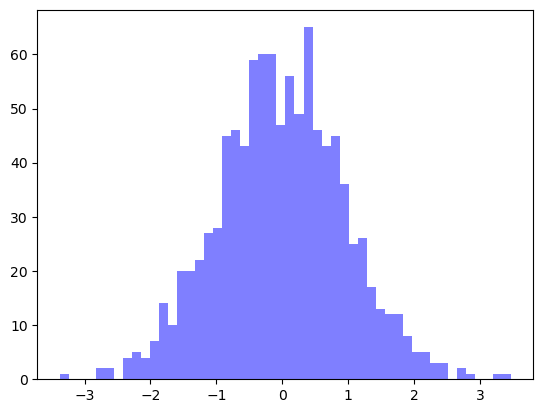

In [174]:
inverse_dist = GMMinv(X, hp, b=bins)
n, bins, patches=plt.hist(inverse_dist,bins,facecolor='blue', alpha=0.5)
plt.savefig('Q5.png')